In [ ]:
import json
import os
from PIL import Image
import glob
import random

# Преобразование
def convert_annotations(json_path, images_dir, labels_dir):
    os.makedirs(labels_dir, exist_ok=True)
    
    with open(json_path, 'r') as f:
        annotations = json.load(f)
    
    for img_name, objects in annotations.items():
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Warning: {img_path} does not exist. Skipping.")
            continue
        
        txt_filename = os.path.splitext(img_name)[0] + '.txt'
        txt_path = os.path.join(labels_dir, txt_filename)
        
        with open(txt_path, 'w') as txt_file:
            for obj_id, obj_info in objects.items():
                if 'team' not in obj_info:
                    continue
                class_id = obj_info['team']
                # Получаем координаты в формате [x_min, y_min, width, height]
                x_min, y_min, w, h = obj_info['box']
                # Конвертируем в YOLO формат [x_center, y_center, width, height]
                x_center = x_min + w / 2
                y_center = y_min + h / 2
                line = f"{class_id} {x_center} {y_center} {w} {h}\n"
                txt_file.write(line)

# Пути к данным (замените на свои)
base_path = "otus_basketball_dataset/"

# Обработка тренировочных данных
# convert_annotations(
#     json_path=os.path.join(base_path, "anno_train.json"),
#     images_dir=os.path.join(base_path, "images_train"),
#     labels_dir=os.path.join(base_path, "labels_train")
# )

# # Обработка тестовых данных
# convert_annotations(
#     json_path=os.path.join(base_path, "anno_test.json"),
#     images_dir=os.path.join(base_path, "images_test"),
#     labels_dir=os.path.join(base_path, "labels_test")
# )

In [2]:
# Проверка на валидность датасета
def validate_yolo_dataset(dataset_path):
    """
    Проверяет валидность аннотаций YOLO в папках train и valid.
    Удаляет невалидные аннотации и соответствующие изображения.
    """
    for split in ['train', 'valid']:
        labels_dir = os.path.join(dataset_path, split, 'labels')
        images_dir = os.path.join(dataset_path, split, 'images')
        
        if not os.path.exists(labels_dir) or not os.path.exists(images_dir):
            print(f"Пропускаем {split}: отсутствуют директории labels/images")
            continue
        
        for label_file in glob.glob(os.path.join(labels_dir, '*.txt')):
            is_valid = True
            image_file = None
            
            base_name = os.path.splitext(os.path.basename(label_file))[0]
            
            for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
                possible_image = os.path.join(images_dir, base_name + ext)
                if os.path.exists(possible_image):
                    image_file = possible_image
                    break
            
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
            except Exception as e:
                print(f"Ошибка чтения {label_file}: {e}")
                is_valid = False
            else:
                for line_num, line in enumerate(lines, 1):
                    line = line.strip()
                    if not line:
                        continue
                    
                    parts = line.split()
                    
                    # Проверка класса
                    try:
                        class_id = int(parts[0])
                        if class_id < 0:
                            print(f"Отрицательный класс в строке {line_num} файла {label_file}")
                            is_valid = False
                            break
                    except (ValueError, IndexError):
                        print(f"Неверный формат класса в строке {line_num} файла {label_file}")
                        is_valid = False
                        break
                    
                    # Проверка координат (первые 4 значения после класса)
                    for i in range(1, 5):
                        try:
                            coord = parts[i]
                            val = float(coord)
                            if not (0.0 <= val <= 1.0):
                                print(f"Некорректное значение координаты {i} в строке {line_num} файла {label_file}: {val}")
                                is_valid = False
                                break
                        except (ValueError, IndexError):
                            print(f"Ошибка в координате {i} строки {line_num} файла {label_file}")
                            is_valid = False
                            break
                    if not is_valid:
                        break
            
            if not is_valid:
                print(f"Удаление невалидной аннотации: {label_file}")
                os.remove(label_file)
                if image_file:
                    print(f"Удаление соответствующего изображения: {image_file}")
                    os.remove(image_file)
                else:
                    print(f"Соответствующее изображение не найдено для {label_file}")

# Пример использования
validate_yolo_dataset('otus_basketball_dataset')

Некорректное значение координаты 2 в строке 4 файла otus_basketball_dataset\train\labels\052768.txt: 1.0117950209974835
Удаление невалидной аннотации: otus_basketball_dataset\train\labels\052768.txt
Удаление соответствующего изображения: otus_basketball_dataset\train\images\052768.jpeg


In [26]:
def get_random_image_name(dataset_path):
    image_names = []
    
    for split in ['train', 'valid']:
        images_dir = os.path.join(dataset_path, split, 'images')
        
        # Собираем имена файлов всех изображений
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']:
            full_paths = glob.glob(os.path.join(images_dir, ext))
            for path in full_paths:
                image_names.append(os.path.basename(path))

    return random.choice(image_names)

otus_basketball_dataset\train\images\056426.jpeg
otus_basketball_dataset\train\labels\056426.txt


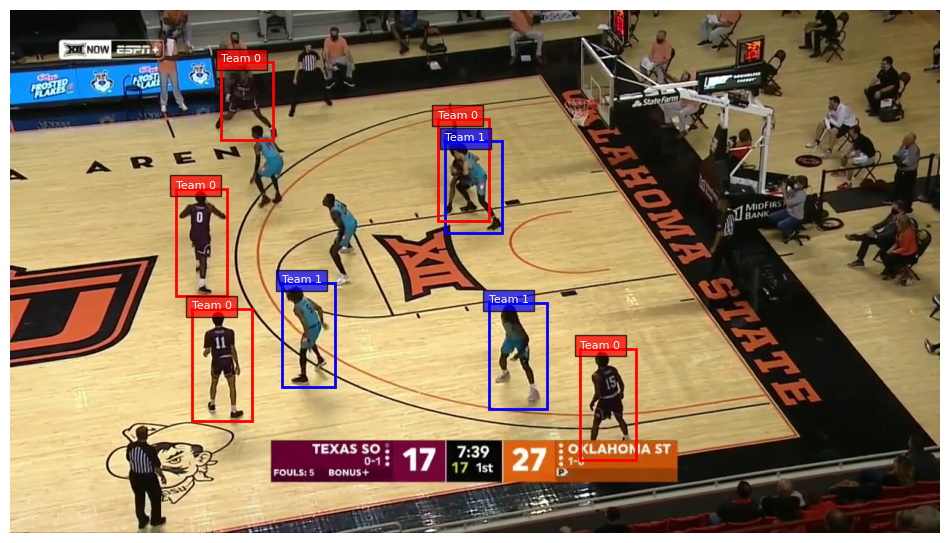

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
base_path = "otus_basketball_dataset"

# Выбор изображения для визуализации
sample_image = get_random_image_name(base_path)  # Замените на имя из вашего датасета
image_path = os.path.join(base_path, "train", "images", sample_image)  # Добавлена папка images
label_path = os.path.join(base_path, "train", "labels", sample_image.replace(".jpeg", ".txt")) 
print(image_path)
print(label_path)

# Загрузка изображения
image = Image.open(image_path)
img_width, img_height = image.size

# Создание фигуры
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Чтение аннотаций YOLO
with open(label_path, 'r') as f:
    annotations = f.readlines()

# Отрисовка BBox
for line in annotations:
    class_id, x_center, y_center, w, h = map(float, line.strip().split())
    x_center *= img_width
    y_center *= img_height
    w *= img_width
    h *= img_height
    x_min = x_center - w /2
    y_min = y_center - h /2
    
    rect = patches.Rectangle(
        (x_min, y_min), w, h,
        linewidth=2, edgecolor='r' if class_id == 0 else 'b', facecolor='none'
    )
    ax.add_patch(rect)
    plt.text(x_min, y_min, f'Team {int(class_id)}', 
             color='white', fontsize=8, 
             bbox=dict(facecolor='red' if class_id == 0 else 'blue', alpha=0.7))

plt.axis('off')
plt.show()

In [69]:
from ultralytics import YOLO

# Загрузка предобученной модели
model = YOLO("yolo11m.pt") # m-версия

In [78]:
# У меня есть NPU модуль, но как выяснилось, он годится только для ускорения инференса! :()
results = model.train(
    data="basketball.yaml",
    epochs=50,
    batch=8,
    imgsz=640,
    device="CPU",  # GPU 
    name="basketball_detection",
    workers=8     # Используем все 16 потоков (workers = ядра * 2)
)

Ultralytics 8.3.145  Python-3.11.9 torch-2.7.0+cu128 CPU (AMD Ryzen 7 PRO 8840HS w/ Radeon 780M Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=basketball.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=basketball_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

train: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\train\labels.cache... 399 images, 0 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.10.0 ms, read: 2085.8649.7 MB/s, size: 220.5 KB)



c:\Users\khari\OneDrive\Документы\GirRep\myenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\khari\OneDrive\Документы\GirRep\OtusCV\Lesson 17\Homework\otus_basketball_dataset\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

Plotting labels to runs\detect\basketball_detection\labels.jpg... 



c:\Users\khari\OneDrive\Документы\GirRep\myenv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\basketball_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.397      1.163      1.109        113        640: 100%|██████████| 50/50 [05:54<00:00,  7.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.85s/it]

                   all        100        660      0.653       0.81      0.675      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.519      1.125      1.176         71        640:  10%|█         | 5/50 [00:38<05:45,  7.68s/it]


KeyboardInterrupt: 